## Importing dependencies and data

In [1]:
import re
import nltk
import string
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#STAGE 1: DATA COLLECTION

Data acquisition concerns the collection of tweets. Each person scraps tweets (about 200k) to create a dataset for further processing. Tweets should be about current events, such as the war, NATO etc.

In [3]:
# Data was scarapped with snsscrapper in scrapper.py file and saved to "data" folder
# Path to data should customized
files = glob.glob("/content/drive/MyDrive/ZUM/Project/Assignment 1/data/tweets*.csv")
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
tweets = pd.concat(dfs, ignore_index=True)
print(len(tweets))


200000



*   a.   Select the number of target classes
*   b.   Clean data and remove stopwords
*   c.   Vectorized representation of words similar in meaning
*   d.   K-MEANS clusters
*   e.   Based on clusters tag data


**a. Number of classes**

In [4]:
num_classes = 3

**b. Cleaning data and removing stopwords**

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
translator = str.maketrans('', '', string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
def clean(df):
    stop_words = set(stopwords.words('english'))
    df['Tweet Text'] = df['Tweet Text'].str.lower()
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: re.sub(r"\S+@\S+", "", x))
    df.drop_duplicates(subset='Tweet Text', inplace=True)
    df['Tweet Text'] = df['Tweet Text'].str.lower()
    df['Tweet Text'] = df['Tweet Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    
    return df

cleanTweets = clean(tweets)
print(len(cleanTweets))
cleanTweets.head()

26525


,Author,Tweet Text,Hashtags
0,tariclaire91,jaderover shonligaya jravenl parvatha24priya s...,NaN
1,wildeyesst66,victorshi2020 fscum zelenskyyua bag ukraine ha...,NaN
2,LiniaSRo,sir kindly join politics quickly else fighting...,NaN
3,HrebeginsSidh,arvind12 itisprashanth actorvijay yeah expecti...,NaN
4,rebekahpierce,wanted make life secret amp war could ruin eve...,['TheSecretLifeOfLucyBosman']


**c. Vectorized representation of words similar in meaning**

In [7]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

cleanTweets['Tokenized Text'] = cleanTweets['Tweet Text'].apply(tokenize_text)
cleanTweets.head()

,Author,Tweet Text,Hashtags,Tokenized Text
0,tariclaire91,jaderover shonligaya jravenl parvatha24priya s...,NaN,"[jaderover, shonligaya, jravenl, parvatha24pri..."
1,wildeyesst66,victorshi2020 fscum zelenskyyua bag ukraine ha...,NaN,"[victorshi2020, fscum, zelenskyyua, bag, ukrai..."
2,LiniaSRo,sir kindly join politics quickly else fighting...,NaN,"[sir, kindly, join, politics, quickly, else, f..."
3,HrebeginsSidh,arvind12 itisprashanth actorvijay yeah expecti...,NaN,"[arvind12, itisprashanth, actorvijay, yeah, ex..."
4,rebekahpierce,wanted make life secret amp war could ruin eve...,['TheSecretLifeOfLucyBosman'],"[wanted, make, life, secret, amp, war, could, ..."


In [8]:
def vectorize(tweet):
    word_embeddings = [model.wv[word] for word in tweet if word in model.wv]
    if len(word_embeddings) > 0:
        return sum(word_embeddings) / len(word_embeddings)
    else:
        return None

model = Word2Vec(cleanTweets['Tokenized Text'], vector_size=100, window=5, min_count=1, workers=4)
cleanTweets['Vectorized Text'] = cleanTweets['Tokenized Text'].apply(vectorize)
cleanTweets = cleanTweets.dropna(subset=['Vectorized Text'])
cleanTweets.head()

,Author,Tweet Text,Hashtags,Tokenized Text,Vectorized Text
0,tariclaire91,jaderover shonligaya jravenl parvatha24priya s...,NaN,"[jaderover, shonligaya, jravenl, parvatha24pri...","[-0.10978227, 0.27825192, 0.34461784, -0.01346..."
1,wildeyesst66,victorshi2020 fscum zelenskyyua bag ukraine ha...,NaN,"[victorshi2020, fscum, zelenskyyua, bag, ukrai...","[-0.3315794, 0.7025372, 0.79955775, 0.07011980..."
2,LiniaSRo,sir kindly join politics quickly else fighting...,NaN,"[sir, kindly, join, politics, quickly, else, f...","[-0.20545433, 0.6671062, 0.7585438, -0.0255871..."
3,HrebeginsSidh,arvind12 itisprashanth actorvijay yeah expecti...,NaN,"[arvind12, itisprashanth, actorvijay, yeah, ex...","[-0.11164588, 0.3436399, 0.40916133, -0.026787..."
4,rebekahpierce,wanted make life secret amp war could ruin eve...,['TheSecretLifeOfLucyBosman'],"[wanted, make, life, secret, amp, war, could, ...","[-0.27014723, 0.7328833, 0.896968, -0.00127700..."


**d.   K-MEANS clusters with 3 classes**

In [9]:
X = np.vstack(cleanTweets['Vectorized Text'].values)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
cleanTweets['Cluster'] = kmeans.labels_
cleanTweets

,Author,Tweet Text,Hashtags,Tokenized Text,Vectorized Text,Cluster
0,tariclaire91,jaderover shonligaya jravenl parvatha24priya s...,NaN,"[jaderover, shonligaya, jravenl, parvatha24pri...","[-0.10978227, 0.27825192, 0.34461784, -0.01346...",1
1,wildeyesst66,victorshi2020 fscum zelenskyyua bag ukraine ha...,NaN,"[victorshi2020, fscum, zelenskyyua, bag, ukrai...","[-0.3315794, 0.7025372, 0.79955775, 0.07011980...",2
2,LiniaSRo,sir kindly join politics quickly else fighting...,NaN,"[sir, kindly, join, politics, quickly, else, f...","[-0.20545433, 0.6671062, 0.7585438, -0.0255871...",0
3,HrebeginsSidh,arvind12 itisprashanth actorvijay yeah expecti...,NaN,"[arvind12, itisprashanth, actorvijay, yeah, ex...","[-0.11164588, 0.3436399, 0.40916133, -0.026787...",1
4,rebekahpierce,wanted make life secret amp war could ruin eve...,['TheSecretLifeOfLucyBosman'],"[wanted, make, life, secret, amp, war, could, ...","[-0.27014723, 0.7328833, 0.896968, -0.00127700...",2
...,...,...,...,...,...,...
190072,Meeszs,rogerclarkpsfc ronfancy tulsigabbard war crimi...,NaN,"[rogerclarkpsfc, ronfancy, tulsigabbard, war, ...","[-0.14715895, 0.51159996, 0.5595165, 0.0326697...",0
190105,RSom67,marcorounder dave24657469 douglasritz spriter9...,NaN,"[marcorounder, dave24657469, douglasritz, spri...","[-0.16786893, 0.51143503, 0.55981404, 0.007361...",0
190137,rp_polirea,number demonrats melting enjoyable,NaN,"[number, demonrats, melting, enjoyable]","[-0.057982255, 0.13277973, 0.1592769, -0.00722...",1
190391,tallal_altohimi,subject cover politics recently,['李连杰'],"[subject, cover, politics, recently]","[-0.3106911, 0.59551084, 0.8257588, -0.1050025...",0


**e. Based on clusters tag data and manually fix clusters if necessary**

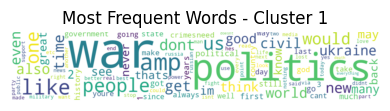

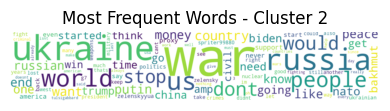

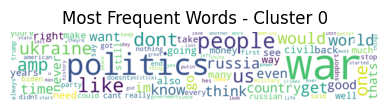

In [10]:
from wordcloud import WordCloud
from collections import Counter

cluster_labels = cleanTweets['Cluster'].unique()
num_words = 100
wordcloud_params = {
    'background_color': 'white',
    'max_words': num_words,
    'width': 1600,
    'height': 300,
    'prefer_horizontal': 0.9,
    'collocations': False
}

for label in cluster_labels:
    cluster_data = cleanTweets[cleanTweets['Cluster'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Cluster {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


**Tagging using SentimentIntensityAnalyzer**

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

cleanTweets['Sentiment'] = cleanTweets['Tweet Text'].apply(lambda x: sia.polarity_scores(x)['compound'])
cleanTweets['Sentiment Label'] = cleanTweets['Sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


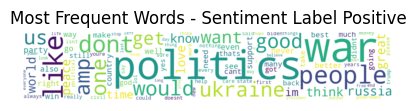

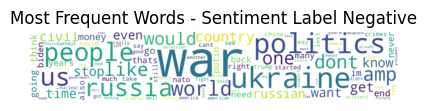

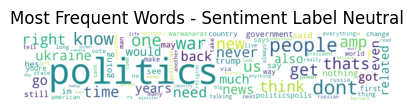

In [12]:
sentiment_labels = cleanTweets['Sentiment Label'].unique()
num_words = 40

for label in sentiment_labels:
    cluster_data = cleanTweets[cleanTweets['Sentiment Label'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Sentiment Label {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


<Figure size 1000x500 with 0 Axes>

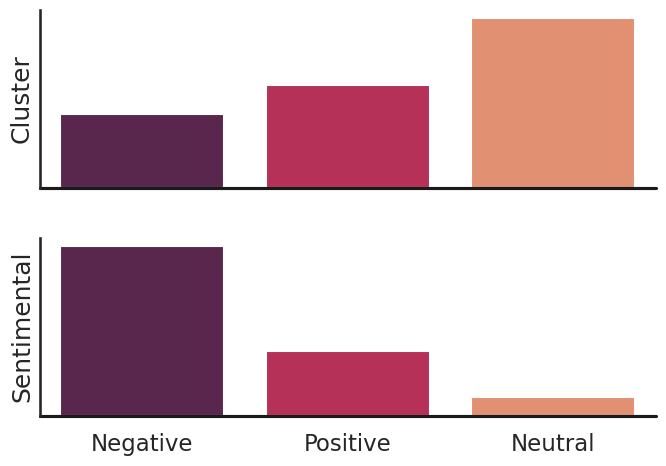

In [111]:
import seaborn as sns

plt.figure(figsize=(10, 5))

sns.set_theme(style="white", context="talk")


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

cluster = cleanTweets['Cluster'].value_counts()
sns.barplot(x=cluster.index, y=cluster.values, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Cluster")

sentimental = cleanTweets['Sentiment Label'].value_counts()
sns.barplot(x=sentimental.index, y=sentimental.values, palette="rocket", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Sentimental")

sns.despine(bottom=True)

plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

**Manually fixing clusters to see difference**

In [112]:
pd.set_option('display.max_colwidth', 1000)
initial_points = cleanTweets.groupby('Sentiment Label').apply(lambda x: x.sample(1)).reset_index(drop=True)
print(initial_points[['Tweet Text','Sentiment Label']])
I = np.vstack(initial_points['Vectorized Text'])
X = np.vstack(cleanTweets['Vectorized Text'].values)
I = I.reshape(3, -1)
kmeans = KMeans(n_clusters=3, init=I, n_init=3)
kmeans.fit(X)
cleanTweets['Cluster'] = kmeans.labels_


                                                                                                                                                                              Tweet Text  \
0                                                                            international criminal court calls verdict war criminal putin unacceptable cant expect anything else ratten   
1  politics race racialisation middle east edited burcuaozcelik explores extent race racialisation offer us explanatory framework study contemporary politics identity middle east today   
2                                      georgiev112 yes days tend laugh things think fad smol ethnoshitates like peaceful liberal democratization really lateendgame cold war development   

  Sentiment Label  
0        Negative  
1         Neutral  
2        Positive  


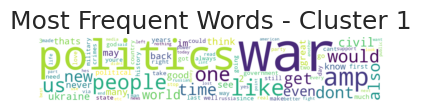

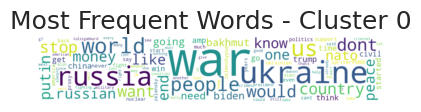

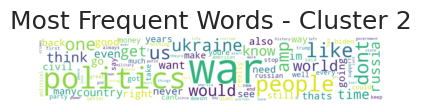

In [113]:
cluster_labels = cleanTweets['Cluster'].unique()
num_words = 100

for label in cluster_labels:
    cluster_data = cleanTweets[cleanTweets['Cluster'] == label]
    cluster_text = ' '.join(cluster_data['Tokenized Text'].apply(lambda x: ' '.join(x)))
    words = cluster_text.split()
    word_frequencies = Counter(words)
    wordcloud = WordCloud(**wordcloud_params)
    wordcloud.generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words - Cluster {label}')
    plt.axis('off')
    plt.tight_layout()

    plt.show()


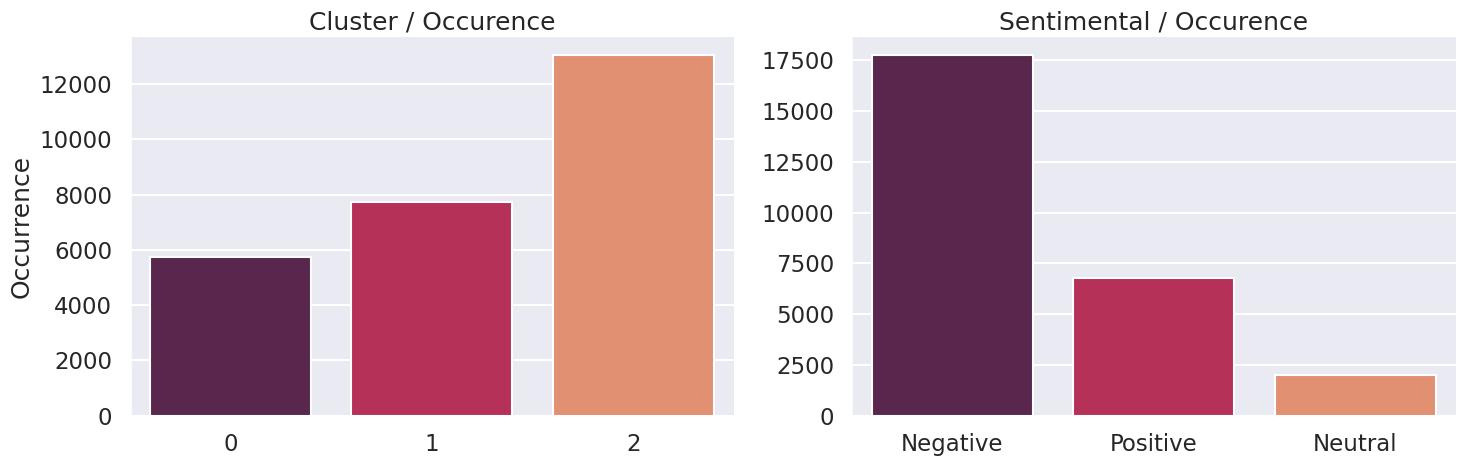

In [115]:
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.set_theme(style="darkgrid", context="talk")

plt.subplot(1, 2, 1)
plt.title('Cluster / Occurence')
plt.ylabel('Occurrence')
cluster = cleanTweets['Cluster'].value_counts()
sns.barplot(x=cluster.index, y=cluster.values, palette="rocket")

plt.subplot(1, 2, 2)
plt.title('Sentimental / Occurence')
sentimental = cleanTweets['Sentiment Label'].value_counts()
sns.barplot(x=sentimental.index, y=sentimental.values, palette="rocket")

# Finalize the plot
sns.despine(bottom=True)

plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [76]:
cleanTweets.to_csv('Tweets.csv', index=False)

# STAGE 2: CLASSIC ML


**Choose 3 models to fit data and present the results with confusion matric and roc curve.**

In [191]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score


X = np.vstack(cleanTweets['Vectorized Text'].values)
X_train, X_test, y_train, y_test = train_test_split(X, cleanTweets['Cluster'], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X_train)
normalized_test = scaler.fit_transform(X_test)

matplotlib.rc_file_defaults()

# Function for ploting matrices and curves
def plot_matrix(model_name, pred, prob, col=plt.cm.Oranges):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    cm = confusion_matrix(y_test, pred)
    class_accuracy = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = axs[0].imshow(class_accuracy, interpolation='nearest', cmap=col)
    axs[0].set_title(f'Confusion Matrix - {model_name}')
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')
    axs[0].set_xticks([0, 1, 2])
    axs[0].set_yticks([0, 1, 2])
    axs[0].set_xticklabels(['Class 0 (Neutral)', 'Class 1 (Negative)', 'Class 2 (Positive)'])
    axs[0].set_yticklabels(['Class 0 (Neutral)', 'Class 1 (Negative)', 'Class 2 (Positive)'])

    for j in range(num_classes):
        for k in range(num_classes):
            axs[0].text(k, j, f'{class_accuracy[j, k]:.2f}', ha='center', va='center', color='black')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_idx in range(num_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(y_test == class_idx, prob)
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    axs[1].plot([0, 1], [0, 1], 'k--', label='Random')
    for class_idx in range(num_classes):
        axs[1].plot(fpr[class_idx], tpr[class_idx], label=f'Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title(f'ROC Curve - {model_name}')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

**1. LogisticRegression**

In [192]:
from sklearn.linear_model import LogisticRegression

reg_model = LogisticRegression()
reg_score = cross_val_score(reg_model, X_train, y_train, cv=5, error_score='raise')
print("LogisticRegression Cross-Validation:", reg_score)

reg_model.fit(X_train, y_train)

LogisticRegression Cross-Validation: [0.99764373 0.99787886 0.99670045 0.99575772 0.99811454]


LogisticRegression()

In [193]:
reg_predictions = reg_model.predict(X_test)
reg_pred_proba = reg_model.predict_proba(X_test)[:, 1]
reg_accuracy = accuracy_score(y_test, reg_predictions)
print("LogisticRegression probability:", reg_accuracy)
print("LogisticRegression accuracy:", reg_accuracy)


LogisticRegression probability: 0.9986804901036758
LogisticRegression accuracy: 0.9986804901036758


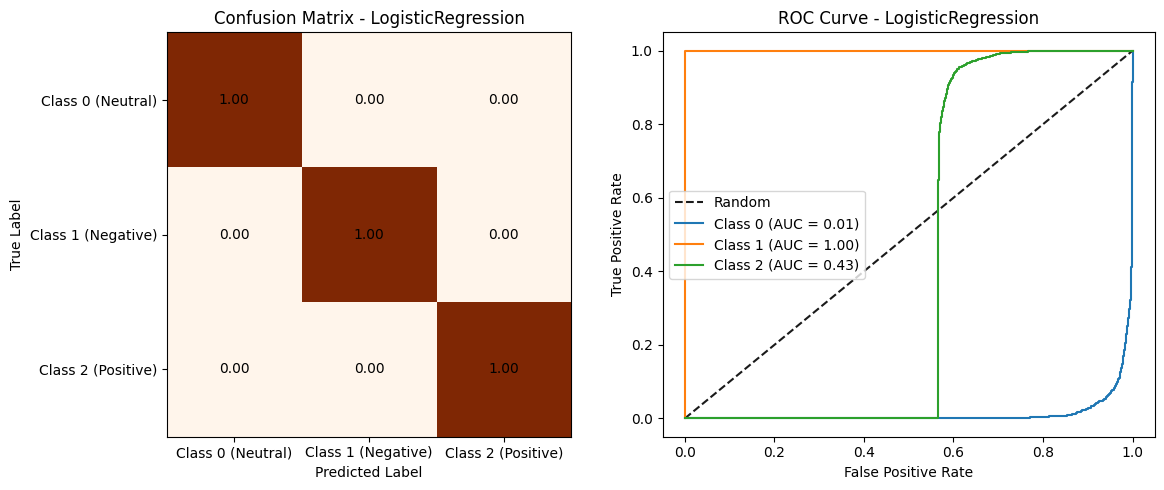

In [194]:
plot_matrix('LogisticRegression', reg_predictions, reg_pred_proba)

**The Logistic Regression model achieved a probability score of 0.9986804901036758, which indicates a high confidence in its predictions. Additionally, the accuracy of the Logistic Regression model was also 0.9986804901036758, suggesting that it accurately classified the majority of the tweets.**

**2.  DecisionTreeClassifier** 

In [195]:
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier()
dtc_score = cross_val_score(dtc_model, X_train, y_train, cv=5, error_score='raise')
print("DecisionTree Cross-Validation:", dtc_score)

dtc_model.fit(X_train, y_train)

DecisionTree Cross-Validation: [0.98562677 0.98609474 0.98279519 0.98114542 0.98750884]


DecisionTreeClassifier()

In [196]:
dtc_predictions = dtc_model.predict(X_test)
dtc_pred_proba = dtc_model.predict_proba(X_test)[:, 1]
dtc_accuracy = accuracy_score(y_test, dtc_predictions)
print("DecisionTreeClassifier probability:", dtc_accuracy)
print("DecisionTreeClassifier Accuracy:", dtc_accuracy)

DecisionTreeClassifier probability: 0.988124410933082
DecisionTreeClassifier Accuracy: 0.988124410933082


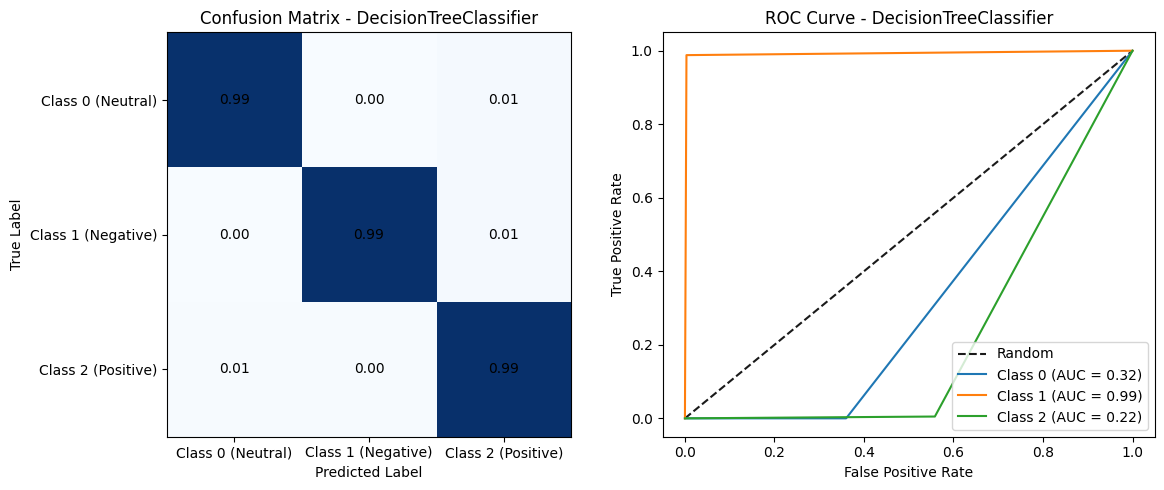

In [201]:
plot_matrix('DecisionTreeClassifier', dtc_predictions, dtc_pred_proba, plt.cm.Blues)

**The Decision Tree Classifier achieved a probability score of 0.988124410933082, indicating a relatively high confidence in its predictions. Additionally, the accuracy of the Decision Tree Classifier was also 0.988124410933082, suggesting that it accurately classified a significant portion of the tweets.**

Similar to the Logistic Regression model, the probability score represents the confidence level of the Decision Tree Classifier in its predictions. A score close to 1 suggests a high degree of certainty, while a score closer to 0 indicates lower confidence. In this case, the relatively high probability score suggests that the Decision Tree Classifier was quite confident in its classifications.

**3. RandomForestClassifier**

In [198]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
rfc_score = cross_val_score(rfc_model, X_train, y_train, cv=5, error_score='raise')
print("RandomForestClassifier Cross-Validation:", rfc_score)

rfc_model.fit(X_train, y_train)

RandomForestClassifier Cross-Validation: [0.99245994 0.9934009  0.99151544 0.99175112 0.99552204]


RandomForestClassifier()

In [199]:
rfc_predictions = rfc_model.predict(X_test)
rfc_pred_proba = rfc_model.predict_proba(X_test)[:, 1]
rfc_accuracy = accuracy_score(y_test, rfc_predictions)
print("RandomForestClassifier probability:", rfc_accuracy)
print("RandomForestClassifier Accuracy:", rfc_accuracy)

RandomForestClassifier probability: 0.9945334590009425
RandomForestClassifier Accuracy: 0.9945334590009425


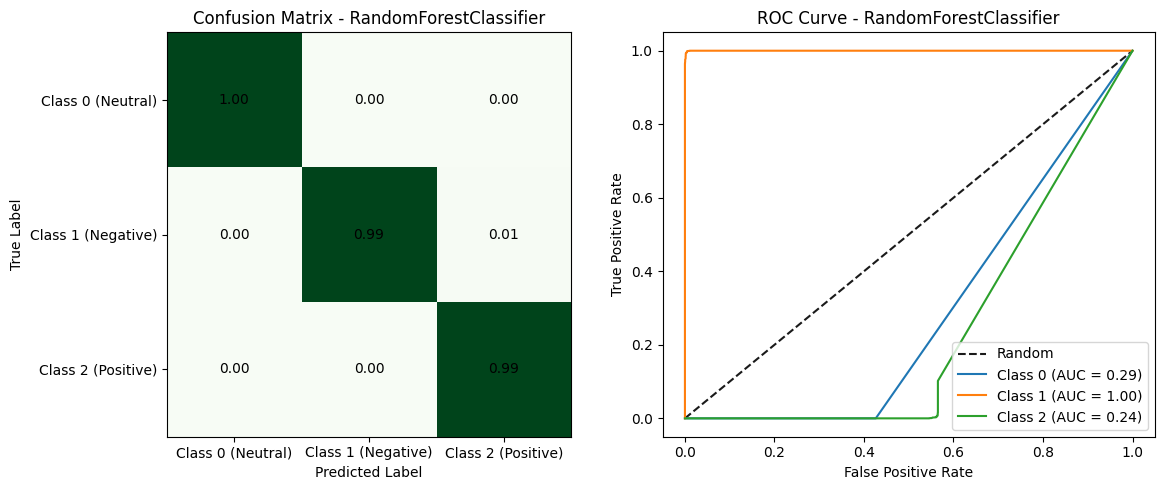

In [200]:
plot_matrix('RandomForestClassifier', rfc_predictions, rfc_pred_proba, plt.cm.Greens)


**The RandomForestClassifier achieved a probability score of 0.9945334590009425, indicating a high level of confidence in its predictions. Additionally, the accuracy of the RandomForestClassifier was also 0.9945334590009425, suggesting that it accurately classified the majority of the tweets as previous models.**

There could be several reasons behind these results. Logistic Regression is a linear model that works well when the relationship between the features and the target variable is linear or can be approximated well by a linear function. In the context of analyzing tweets about war, it's possible that the relationship between the textual features in the tweets and the sentiment or relevance to war is more linear in nature, which favors the performance of Logistic Regression.

On the other hand, Decision Trees and Random Forests are non-linear models that can capture more complex relationships between the features and the target variable. However, they can be prone to overfitting, especially when dealing with high-dimensional data such as text. The Decision Tree model may have exhibited slightly lower performance compared to Random Forest due to its tendency to create overly complex decision boundaries that can lead to overfitting on the training data.

In [202]:
import joblib
joblib.dump(reg_model, 'LogisticRegression_model.pkl')

['LogisticRegression_model.pkl']

# STAGE 3: NEURAL MODEL

**Choose type of neural network to train, and through validation decide on the best set of parameters. It is not enough to just build a model and get results. Fine-tuning is necessary too.**

I chose LSTM because it is a type of recurrent neural network that is particularly effective for text processing tasks. LSTM is designed to overcome the vanishing gradient problem in traditional RNNs, which makes it more effective in capturing long-term dependencies in text data. Text often contains sequences of words or characters where the meaning of a word can depend on its context and previous words. LSTM's ability to remember and propagate information over longer sequences makes it well-suited for modeling such dependencies.

In [209]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tabulate import tabulate

X = np.array(cleanTweets['Vectorized Text'])
y = np.array(cleanTweets['Cluster'])
X_concatenated = np.concatenate(X, axis=0)

X_reshaped = np.reshape(X_concatenated, (len(X), X[0].shape[0],1))

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(8, input_shape=(100, 1))) 
model.add(Dense(8, activation='relu'))  
model.add(Dense(3, activation='softmax'))  
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
loss, accuracy = model.evaluate(X_val, y_val)
print('Validation Loss:', loss) 
print('Validation Accuracy:', accuracy)

Epoch 1/10
663/663 [==============================] - 19s 25ms/step - loss: 0.6503 - accuracy: 0.7635 - val_loss: 0.2308 - val_accuracy: 0.9274
Epoch 2/10
663/663 [==============================] - 16s 25ms/step - loss: 0.1691 - accuracy: 0.9426 - val_loss: 0.1089 - val_accuracy: 0.9629
Epoch 3/10
663/663 [==============================] - 17s 26ms/step - loss: 0.1202 - accuracy: 0.9556 - val_loss: 0.0715 - val_accuracy: 0.9761
Epoch 4/10
663/663 [==============================] - 17s 26ms/step - loss: 0.1033 - accuracy: 0.9601 - val_loss: 0.1019 - val_accuracy: 0.9557
Epoch 5/10
663/663 [==============================] - 20s 30ms/step - loss: 0.1005 - accuracy: 0.9598 - val_loss: 0.0728 - val_accuracy: 0.9776
Epoch 6/10
663/663 [==============================] - 19s 29ms/step - loss: 0.0843 - accuracy: 0.9662 - val_loss: 0.0929 - val_accuracy: 0.9557
Epoch 7/10
663/663 [==============================] - 19s 29ms/step - loss: 0.0908 - accuracy: 0.9645 - val_loss: 0.1205 - val_accuracy:

In [210]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

166/166 [==============================] - 2s 7ms/step


In [211]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

y_train_multiclass = np.argmax(y_train_pred, axis=1)
y_val_multiclass = np.argmax(y_val_pred, axis=1)
f1_train = f1_score(y_train, y_train_multiclass, average='weighted')
f1_val = f1_score(y_val, y_val_multiclass, average='weighted')

metrics_data = {
    'Metric': ['Train Accuracy', 'Validation Accuracy', 'Train F1 Score', 'Validation F1 Score'],
    'Value': [train_accuracy[-1], val_accuracy[-1], f1_train, f1_val]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_table = metrics_df.values.tolist()

print(tabulate(metrics_table, headers=metrics_df.columns, tablefmt="fancy_grid"))

╒═════════════════════╤══════════╕
│ Metric              │    Value │
╞═════════════════════╪══════════╡
│ Train Accuracy      │ 0.9671   │
├─────────────────────┼──────────┤
│ Validation Accuracy │ 0.9623   │
├─────────────────────┼──────────┤
│ Train F1 Score      │ 0.962343 │
├─────────────────────┼──────────┤
│ Validation F1 Score │ 0.962466 │
╘═════════════════════╧══════════╛


Fine-tuning LSTM model to find best model

In [212]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(units, activation):
    model = Sequential()
    model.add(LSTM(units, input_shape=(100, 1)))
    model.add(Dense(units, activation=activation))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

modelUpd = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'units': [16, 32],
    'activation': ['relu', 'tanh']
}

grid_search = GridSearchCV(estimator=modelUpd, param_grid=param_grid, cv=3)

grid_result = grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

663/663 [==============================] - 20s 27ms/step - loss: 0.3914 - accuracy: 0.8334
Best Hyperparameters:  {'activation': 'relu', 'units': 32}
Best Accuracy:  0.9242552717526754


In [213]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
663/663 [==============================] - 22s 30ms/step - loss: 0.3940 - accuracy: 0.8325 - val_loss: 0.1450 - val_accuracy: 0.9410
Epoch 2/10
663/663 [==============================] - 20s 30ms/step - loss: 0.1747 - accuracy: 0.9297 - val_loss: 0.1031 - val_accuracy: 0.9623
Epoch 3/10
663/663 [==============================] - 19s 29ms/step - loss: 0.1384 - accuracy: 0.9435 - val_loss: 0.1082 - val_accuracy: 0.9629
Epoch 4/10
663/663 [==============================] - 20s 30ms/step - loss: 0.1220 - accuracy: 0.9500 - val_loss: 0.0978 - val_accuracy: 0.9570
Epoch 5/10
663/663 [==============================] - 20s 29ms/step - loss: 0.1200 - accuracy: 0.9512 - val_loss: 0.0800 - val_accuracy: 0.9721
Epoch 6/10
663/663 [==============================] - 21s 31ms/step - loss: 0.1044 - accuracy: 0.9560 - val_loss: 0.1002 - val_accuracy: 0.9576
Epoch 7/10
663/663 [==============================] - 19s 29ms/step - loss: 0.0968 - accuracy: 0.9608 - val_loss: 0.0892 - val_accuracy:

In [214]:
train_accuracy = best_model.score(X_train, y_train)
y_train_pred = best_model.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

val_accuracy = best_model.score(X_val, y_val)
y_val_pred = best_model.predict(X_val)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

166/166 [==============================] - 2s 10ms/step


In [215]:
metrics_data = {
    'Metric': ['Train Accuracy', 'Validation Accuracy', 'Train F1 Score', 'Validation F1 Score'],
    'Value': [train_accuracy, val_accuracy, f1_train, f1_val]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_table = metrics_df.values.tolist()

print(tabulate(metrics_table, headers=metrics_df.columns, tablefmt="fancy_grid"))

╒═════════════════════╤══════════╕
│ Metric              │    Value │
╞═════════════════════╪══════════╡
│ Train Accuracy      │ 0.970305 │
├─────────────────────┼──────────┤
│ Validation Accuracy │ 0.975306 │
├─────────────────────┼──────────┤
│ Train F1 Score      │ 0.962343 │
├─────────────────────┼──────────┤
│ Validation F1 Score │ 0.962466 │
╘═════════════════════╧══════════╛


The obtained results appear to be better than previous. However, there is an opportunity for further optimization. increased complexity acieved even better performance scores.

In [216]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

#STAGE 4: LANGUAGE MODEL

**The last stage is to use selected language model, e.g. BERT, to create a sentiment analysis classifier.**

DistilBERT generates contextualized word embeddings, which means that the meaning of a word can change based on its context within a sentence. This contextual understanding enables the model to capture fine-grained sentiment nuances and subtle contextual cues, leading to more accurate sentiment analysis results.

In [ ]:
pip install git+https://github.com/huggingface/transformers

In [15]:
from transformers import DistilBertTokenizer, TFDistilBertModel, TFDistilBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [ ]:
# cleanTweets = glob.glob("/content/drive/MyDrive/ZUM/Project/Assignment 1/data/Tweets.csv")

In [16]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

y = cleanTweets['Cluster']
X = [str(i) for i in cleanTweets['Tweet Text'].values]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [17]:
train_encodings = tokenizer(X_train, truncation = True, padding = True)
val_encodings = tokenizer(X_val, truncation = True, padding = True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))

In [18]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [19]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100,
)
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5 )
trainer = TFTrainer(
    model=trainer_model,                 
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [20]:
# trainer.train()
trainer.evaluate()

{'eval_loss': 1.656599665262613}

In [22]:
save_directory = "/content/drive/MyDrive/ZUM/Project/Assignment 1/models" 

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/ZUM/Project/Assignment 1/scripts/tokenizer_config.json',
 '/content/drive/MyDrive/ZUM/Project/Assignment 1/scripts/special_tokens_map.json',
 '/content/drive/MyDrive/ZUM/Project/Assignment 1/scripts/vocab.txt',
 '/content/drive/MyDrive/ZUM/Project/Assignment 1/scripts/added_tokens.json')